In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from shapely import wkt
import gc
import pickle
import cartopy.crs as ccrs

In [6]:
import os

def count_files_with_extension(directory, extension):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                count += 1
    return count

# Example usage:
directory_path = '/home/udas/Desktop/UD_Data_Copy/b.final_burned_area'
extension = '.nc'  # specify the extension
count = count_files_with_extension(directory_path, extension)
print(f'There are {count} files with the {extension} extension.')


There are 17859 files with the .nc extension.


### Fire Distribution Per Year

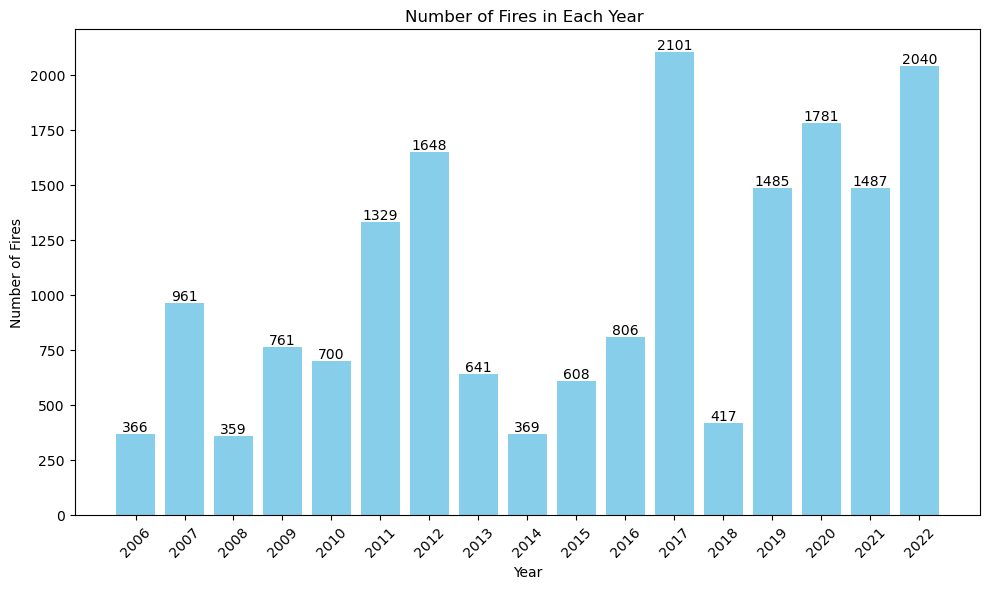

In [29]:




# Dictionary to store year and number of files
year_file_count = {}

# Iterate over each subfolder in the directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Count the number of files in the folder
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        year_file_count[folder] = num_files

# Sort the dictionary by year (folder name)
year_file_count = dict(sorted(year_file_count.items()))

# Plotting
plt.figure(figsize=(10, 6))
bars=plt.bar(year_file_count.keys(), year_file_count.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.title('Number of Fires in Each Year ')
plt.xticks(rotation=45)

#Adding the number labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


plt.tight_layout()
plt.show()


### Distribution of Burned Area Sizes

In [13]:
def get_burned_area_size(root,area_file):
    
    area_list=[]

    with open(area_file,'ab') as f:
        for year in tqdm(os.listdir(root)):
            year_path=os.path.join(root,year)
            print(year_path)

            if os.path.isdir(year_path):
                for file in tqdm(os.listdir(year_path),leave=False):
                    if file.endswith(".nc"):
        
                        file_path = os.path.join(year_path,file)
                        # print(file_path)
                        dataset=xr.open_dataset(file_path)
                        ignition_point=dataset['ignition_points'].isel(time=-1).values
                        # print(ignition_point.shape)
                        fire_indices=np.argwhere(ignition_point>0)
                        # print(f' fire indices shape {fire_indices.shape}')
                        if fire_indices.shape[0]>1:
                            area=0
                            for idx in fire_indices:
                                # print(f'Inside multiple ignitions')
                                row,col=idx
                                # print(f'area is {area}')
                                # print(f'ind area is {ignition_point[row,col]}')
                                # print(f'sum is {area+ignition_point[row,col]}')
                                area+=ignition_point[row,col]
                                # print(f'new area is {area}')
                            area_list.append(area)
                        else:
                            # print(f'Inside single ignition')
                            # print(fire_indices)
                            row,col=fire_indices[0]
                            # print(row,col)
                            area=ignition_point[row,col]
                            # print(f'area is {area}')
                            
                        pickle.dump(area_list,f)
                        dataset.close()

    return np.array(area_list)

def pickle_load_area(filepath):
    with open(filepath, 'rb') as f:
        area_list = []
        while True:
            try:
                # Load individual areas and append to the list
                area_list.append(pickle.load(f))
            except EOFError:
                break
    return np.array(area_list)

def plot_area_size(area_list):
    plt.figure(figsize=(10, 6))
    plt.hist(area_list, bins=100, color='lightcoral', edgecolor='black')
    plt.xlabel('Burned Area (in hectares)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Burned Areas from Ignition Points')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [14]:
area_file='./areas.pkl'
area_list=get_burned_area_size(directory,area_file)
area_list=pickle_load_area(area_file)
print(len(area_list))

# plot_area_size(area_list)

  0%|          | 0/18 [00:00<?, ?it/s]

/home/udas/Desktop/UD_Data_Copy/b.final_burned_area/2020


In [ ]:
plot_area_size(area_list)